In [2]:
def load_UCL_OPM(raw_name, chan_name, json_file, pos_file):
    # Import the necessary packages
    import numpy as np
    import matplotlib.pyplot as plt
    import mne
    import pandas as pd
    import json

    # Load 1D data from .bin file
    d = np.fromfile(raw_name,'>f4')
    
    print('Data loaded as: ' + str(d.dtype))
    
    # Load tsv channels file
    tsv = pd.read_csv(chan_name,sep='\t')
    
    # Replace the channel types with a
    tsv['type'] = tsv['type'].replace('MEGMAG','mag')
    tsv['type'] = tsv['type'].replace('TRIG','stim')
    tsv['type'] = tsv['type'].replace('REF','ref_meg')
    
    # Replace Flux channels with misc
    tsv.loc[tsv.name.str.contains('Flux'), 'type'] = 'misc'
    
    # Put these into a list
    chans = tsv['name'].values.tolist()
    types = tsv['type'].values.tolist()
    
    # Open the _meg.json and extract the sampling freq
    with open(chan_json) as json_file:
        json_meg = json.load(json_file)

    Fs = json_meg['SamplingFrequency']
    
#     # Make a montage
#     pos_tsv = pd.read_csv(pos_file,sep='\t')

#     dict = {}

#     for e in np.arange(0,len(pos_tsv)):
#         dict[pos_tsv.name[e]] = np.array([pos_tsv.Px[e]/1000,pos_tsv.Py[e]/1000,pos_tsv.Pz[e]/1000])

#     montage_opm = mne.channels.make_dig_montage(ch_pos=dict,coord_frame='mri')
    
    # Create MNE info field
    inf = mne.create_info(chans, Fs, ch_types = types, verbose=None)
    
    # Reshape the 1D data into 2D based on the number of channels present
    d2 = np.reshape(d, [len(chans), int(len(d)/len(chans))],'F')
    
    # Create raw MNE object
    raw = mne.io.RawArray(d2, inf, first_samp=0, copy='auto', verbose=None)
    
    return raw
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import json
import os.path as op
from mne.io import read_raw_fif

In [3]:
%matplotlib qt

In [4]:
# Path to data
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG'
data_dir        = '/Volumes/Robert T5/22_09_2020_benchmarking/'
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/'

In [5]:
raw_name               = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_meg.bin')
raw_emptyroom_name     = op.join(data_dir, 'sub-001/', 'ses-001/','meg/','sub-001_ses-001_task-noise_run-001_meg.bin')
chan_name              = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_channels.tsv')
chan_json              = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_meg.json')
pos_file               = op.join(data_dir, 'sub-NA/', 'ses-001/','meg/','sub-NA_ses-001_task-MMF_run-001_positions.tsv')

In [6]:
raw       = load_UCL_OPM(raw_name, chan_name, chan_json, pos_file)
raw_noise = load_UCL_OPM(raw_emptyroom_name, chan_name, chan_json, pos_file)

Data loaded as: >f4
Creating RawArray with float64 data, n_channels=77, n_times=4504140
    Range : 0 ... 4504139 =      0.000 ...   750.690 secs
Ready.
Data loaded as: >f4
Creating RawArray with float64 data, n_channels=77, n_times=1080540
    Range : 0 ... 1080539 =      0.000 ...   180.090 secs
Ready.


In [7]:
from mne.preprocessing import ICA

In [9]:
raw.resample(600)

1567 events found
Event IDs: [1 2 3 4 5]
1457 events found
Event IDs: [2 3 4 5]


<RawArray | 77 x 450414 (750.7 s), ~264.8 MB, data loaded>

In [23]:
raw = raw.filter(l_freq=2,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 991 samples (1.652 sec)



Fitting ICA to data using 70 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 60 components
 
Fitting ICA took 165.4s.


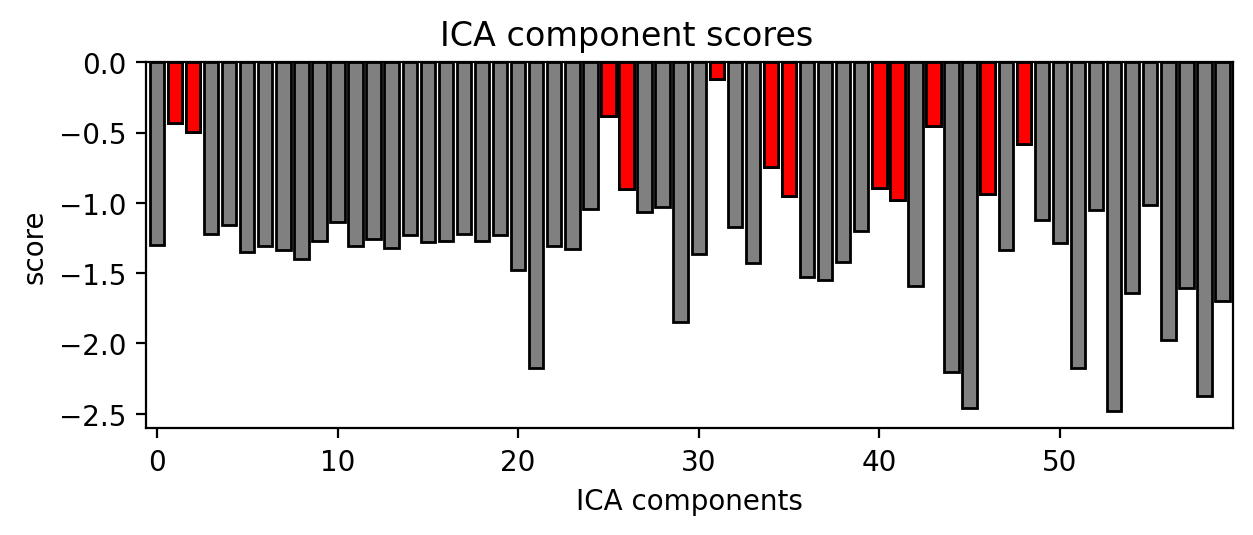

In [24]:
raw_tog = raw.copy()
all_picks = mne.pick_types(raw_tog.info, meg=True, ref_meg=True)
ica_tog = ICA(n_components=60, method="infomax", allow_ref_meg=True)
ica_tog.fit(raw_tog, picks=all_picks)
bad_comps, scores = ica_tog.find_bads_ref(raw_tog, threshold=1)

# Plot scores with bad components marked
ica_tog.plot_scores(scores, bad_comps)

In [25]:
# Examine the properties of removed components. It's clear from the time
# courses and topographies that these components represent external,
# intermittent noise.
# ica_tog.plot_properties(raw_tog,picks=bad_comps)

# Remove the components
raw_tog = ica_tog.apply(raw_tog, exclude=bad_comps)



Transforming to ICA space (60 components)
Zeroing out 12 ICA components


Effective window size : 3.413 (s)


<ipython-input-27-ec1afa19afec>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_tog.plot_psd(fmax=30)


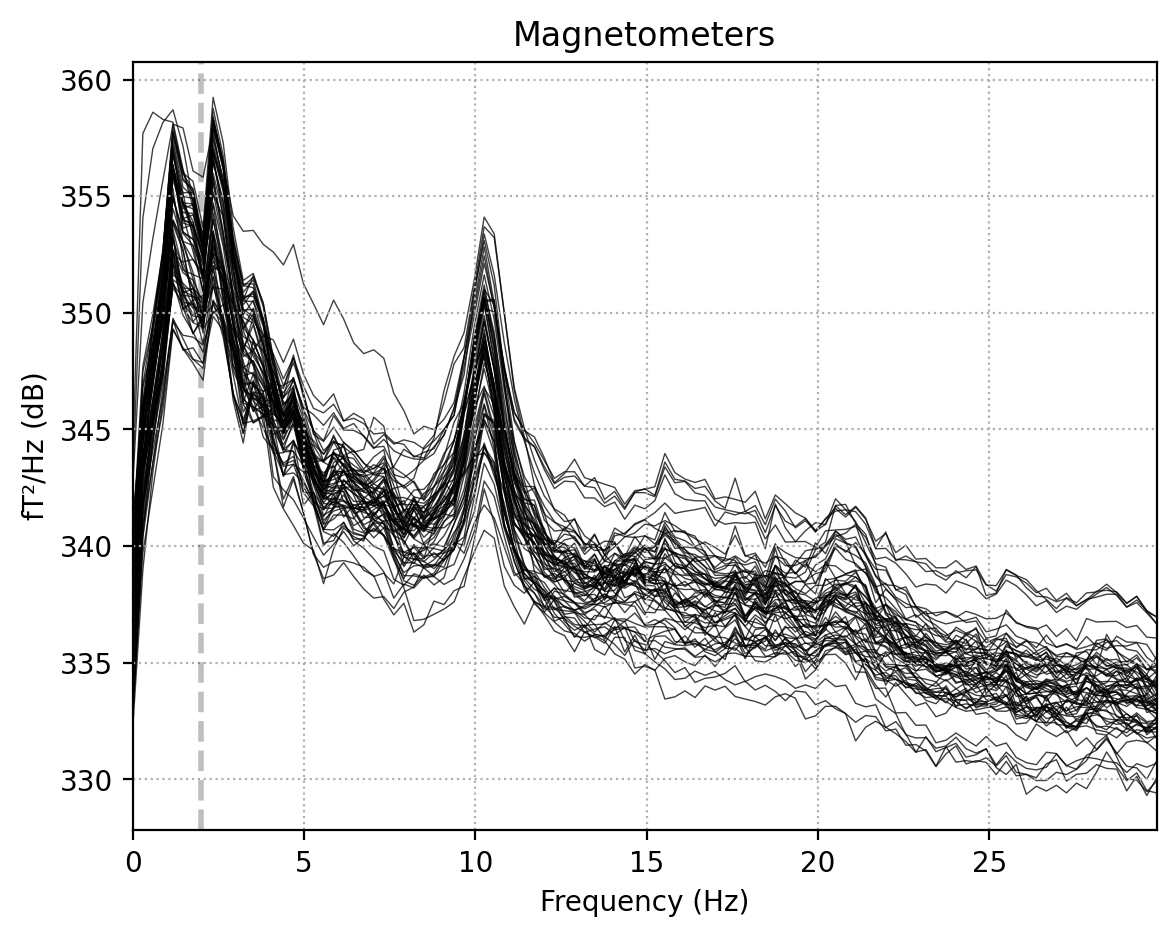

In [27]:
###############################################################################
# Cleaned data
raw_tog.plot_psd(fmax=30)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 6 components
Fitting ICA took 4.9s.
Fitting ICA to data using 70 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 60 components
 
Fitting ICA took 169.5s.


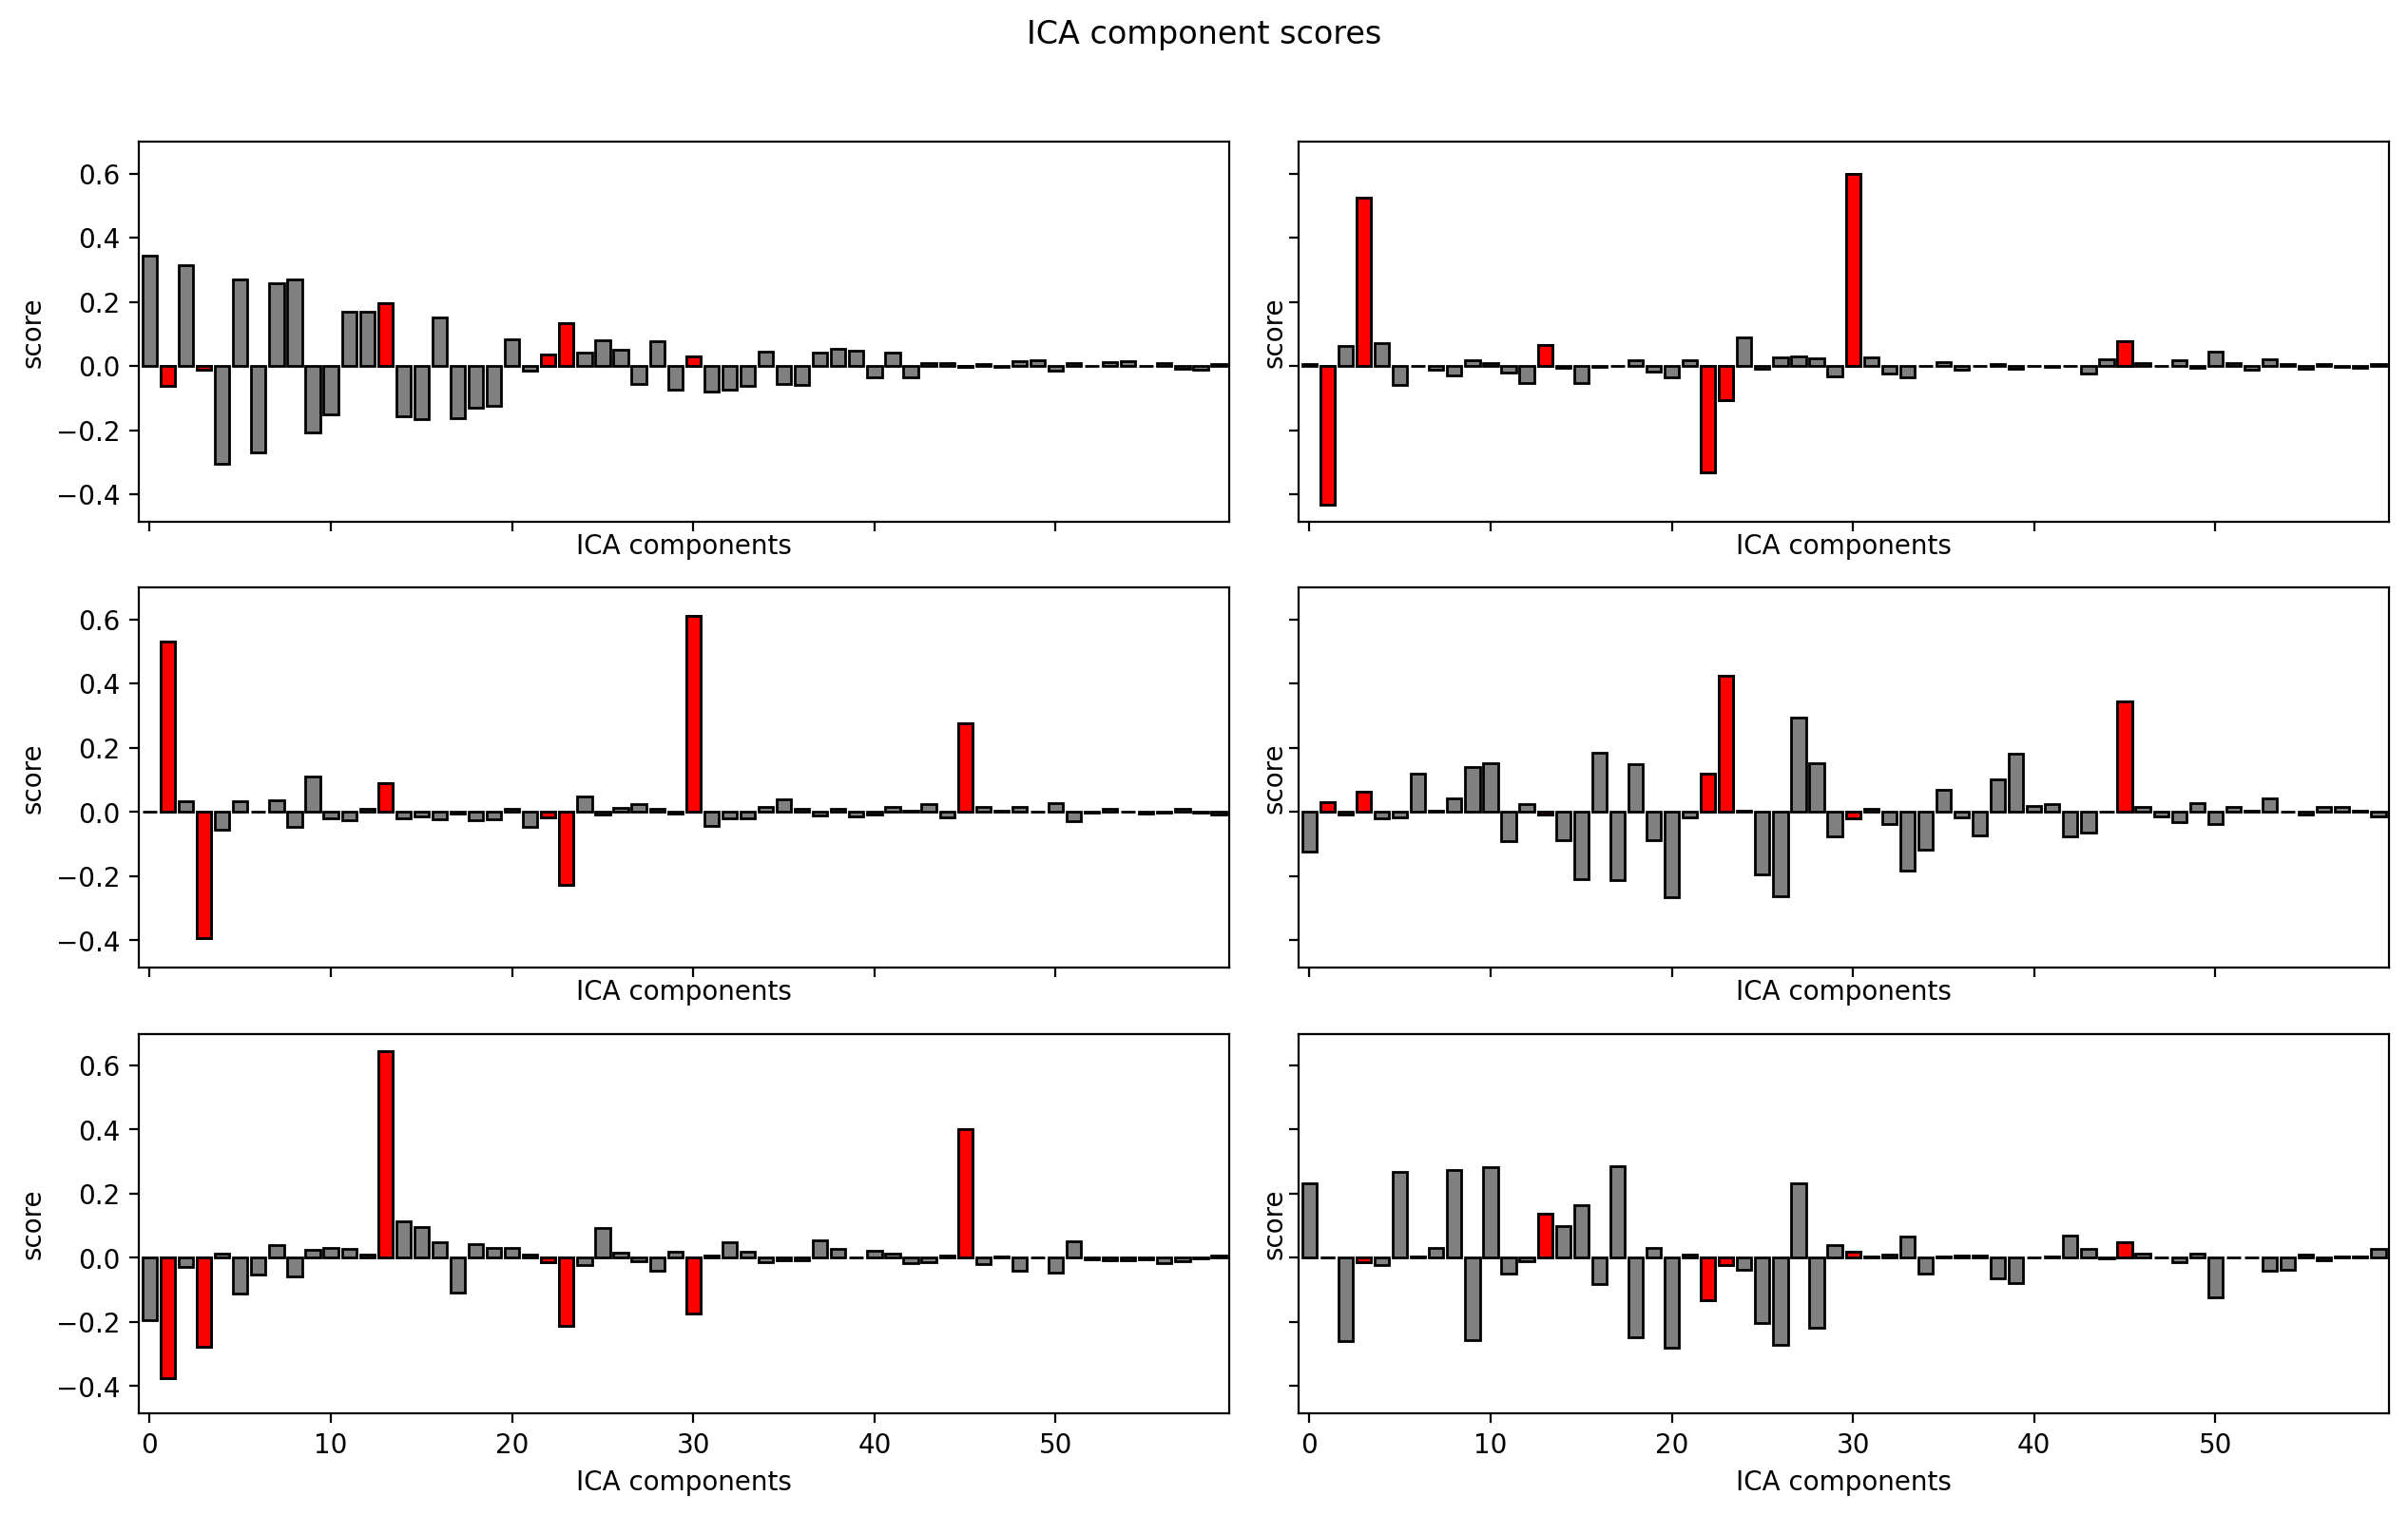

In [28]:
# Now try the "separate" algorithm
raw_sep = raw.copy()

# Do ICA only on the reference channels
ref_picks = mne.pick_types(raw_sep.info, meg=False, ref_meg=True)
ica_ref = ICA(n_components=6, allow_ref_meg=True)
ica_ref.fit(raw_sep, picks=ref_picks)

# Do ICA on both reference and standard channels
ica_sep = ICA(n_components=60, method="infomax", allow_ref_meg=True)
ica_sep.fit(raw_sep, picks=all_picks)

# Extract the time courses of these components and add them as channels
# to the raw data. Think of them the same way as EOG/EKG channels, but instead
# of giving info about eye movements/cardiac activity, they give info about
# external magnetic noise
ref_comps = ica_ref.get_sources(raw_sep)
for c in ref_comps.ch_names: # they need to have REF_ prefix to be recognised
    ref_comps.rename_channels({c:"REF_" + c})
raw_sep.add_channels([ref_comps])

# Now that we have our noise channels, we run the separate algorithm.
bad_comps, scores = ica_sep.find_bads_ref(raw_sep, method="separate")

# Plot scores with bad components marked
ica_sep.plot_scores(scores, bad_comps)

Transforming to ICA space (60 components)
Zeroing out 7 ICA components
Effective window size : 3.413 (s)


<ipython-input-31-e22a6b8e222f>:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=30)


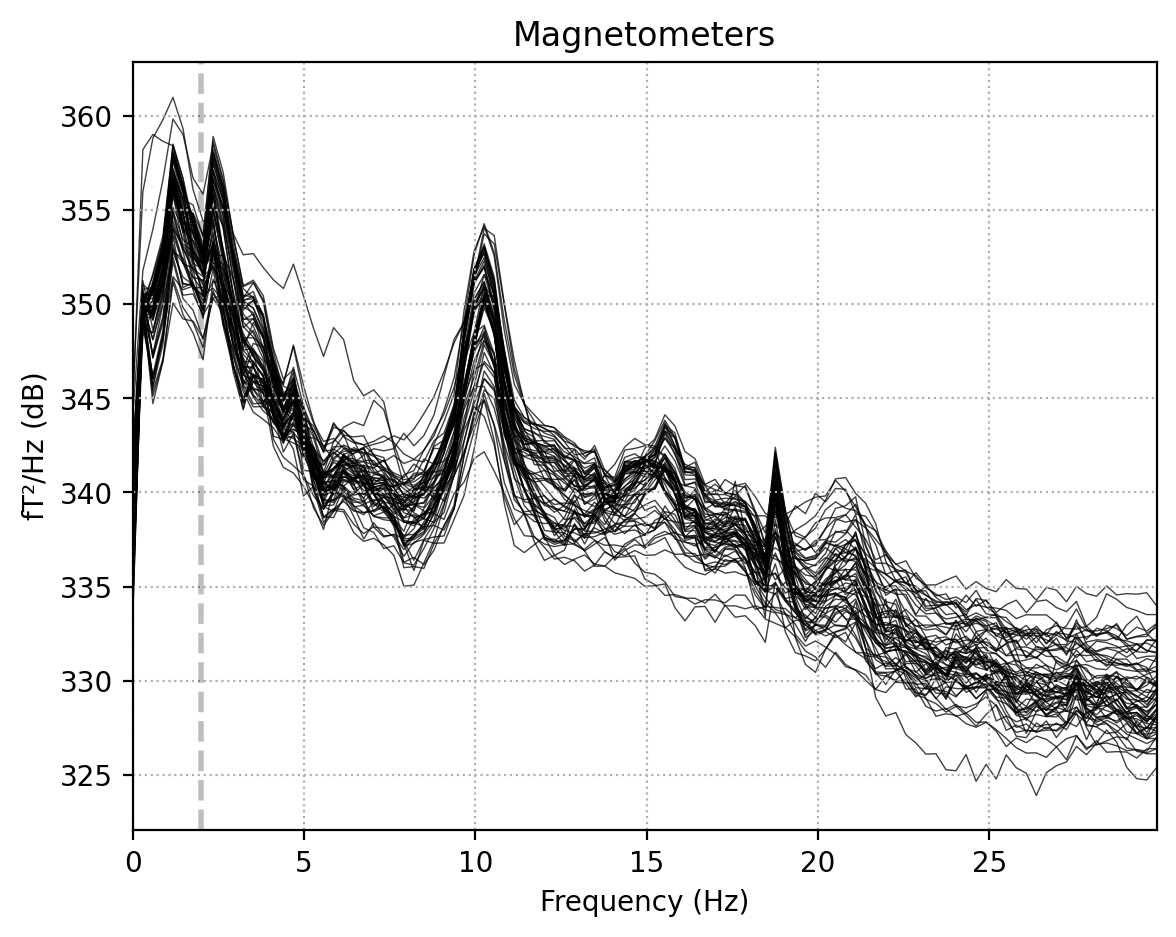

In [31]:
# Remove the components
raw_sep = ica_sep.apply(raw_sep, exclude=bad_comps)

raw.plot_psd(fmax=30)